In [ ]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit,fsolve
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['errorbar.capsize'] = 12
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False

enss=['b']
ens2full={'a24':'cA211.53.24','a':'cA2.09.48','b':'B64','c':'C80','d':'D96'}
ens2label={'a24':'A24','a':'A48','b':'B64','c':'C80','d':'D96'}
ens2a={'a24':0.0908,'a':0.0938,'b':0.07957,'c':0.06821,'d':0.05692} # fm
ens2N={'a24':24,'a':48,'b':64,'c':80,'d':96}
ens2N_T={'a24':24*2,'a':48*2,'b':64*2,'c':80*2,'d':96*2}

# ens2mN={'a':931}
# ens2mpiC={'a':131}
# ens2mpi0={'a':111}

ens2amu={'a24':0.0053,'a':0.0009,'b':0.00072}
ens2ZP={'a24':(0.4670,0.0046),'a':(0.500,0.030)}

hbarc = 1/197.3
ens2aInv={ens:1/(ens2a[ens]*hbarc) for ens in enss} # MeV

def fsolve2(func,x0):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res=fsolve(func, x0)[0]
    return res if res!=x0 else np.NaN

ens='b'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
Tpack=32; d_jk=1
path='/capstor/store/cscs/userlab/lp139/lyan/code/projectData/01_Nsgm/data/Nsgm_4src_16,18,20_cB211.072.64.h5'
data=yu.load(path,d=d_jk)
Ncfg,Njk=data['cfgs'][1:]
print(f'Ncfg={Ncfg},Njk={Njk}')

cfg2old=lambda cfg: cfg[1:]+'_r'+{'a':'0','b':'1','c':'2','d':'3'}[cfg[0]]
cfg2new=lambda cfg: {'0':'a','1':'b','2':'c','3':'d'}[cfg[-1]] + cfg[:4]

tfs=[8,10,12,14,16,18,20]
path='/capstor/store/cscs/userlab/lp139/lyan/code/projectData/01_Nsgm/data_from_others/thrp-conn.h5'
with h5py.File(path) as f:
    # cfgs_NJN=[cfg2new(cfg) for cfg in f['gS/up/dt10'].keys()]
    cfgs_old=[cfg2old(cfg) for cfg in data['cfgs'][0]]

    c3ptDic_NJN={tf:np.real(yu.jackknife([f[f'gS/up/dt{tf}/{cfg}'][:] + f[f'gS/dn/dt{tf}/{cfg}'][:] for cfg in cfgs_old],d=d_jk)) for tf in tfs}
    c2ptCorrDic_NJN={tf:np.real(yu.jackknife([f[f'dt{tf}_twop/{cfg}'][()] for cfg in cfgs_old],d=d_jk)) for tf in tfs}

loading: /capstor/store/cscs/userlab/lp139/lyan/code/projectData/01_Nsgm/data/Nsgm_4src_16,18,20_cB211.072.64.h5
498/498: diags/Z3pt/srcs/Z3pt.h5_NJNpi-Nsrc=4*1                                     
Ncfg=732,Njk=732


In [6]:
flags={
    'cc2pt':True, # average quantities related by complex conjugation for 2pt
    'cc3pt':True, # same for 3pt (Removal of vacuum expectation value requires 'cc2pt'=='cc3pt')
    'll2pt':True, # average irrep rows 'l1' and conjugated 'l2' (Parity breaking effect of tmQCD has been taken care of)
    'll3pt':True, # same for 3pt (This flag has no effect if 'll2pt'=True and spin-projection is done)
    'r2pt': True, # making 2ptMat real for the rest frame # 'll2pt' has to be real for this flag
    'remove_pi0VEV':True, 
    'remove_jVEV':True,
}

def op_remove_pi0(op):
    t=op.split(';')
    if t[-1] in ['p','n','n,pi+']:
        return False
    if t[3] not in ['N0pi0,a','N1pi0,a','N0sgm0,a','N1sgm0,a']:
        return False
    if t[3] in ['N0sgm0,a','N1sgm0,a']:
        t[3]='a'
        t[-1]={'p,sgm':'p'}[t[-1]]
        return ';'.join(t)
    if t[2] == 'G1u':
        t[2]='G1g'
        assert(t[3]=='N0pi0,a'); t[3]='a'
        assert(t[-1]=='p,pi0'); t[-1]='p'
        return ';'.join(t)

def get2pt_diag(opa,opb,diag):
    opab=f'{opa}_{opb}'
    if opab not in data['2pt'].keys() or diag not in data['2pt'][opab].keys():
        return 0
    res=data['2pt'][opab][diag].copy()
    if not flags['remove_pi0VEV']:
        return res
    if diag == 'pi0f-pi0i':
        if opa==opb and opa=='t;0,0,0;pi0':
            res -= (data['VEV']['pi0f']**2)[:,None]
        return res
    
    if 'pi0f' in diag.split('-'):
        t_opa=op_remove_pi0(opa)
        if t_opa != False:
            t=diag.split('-'); t.remove('pi0f'); t_diag='-'.join(t)
            res -= data['2pt'][f'{t_opa}_{opb}'][t_diag] * data['VEV']['pi0f'][opa.split(';')[-1].split(',')[-1]][:,None]
    if 'pi0i' in diag.split('-'):
        t_opb=op_remove_pi0(opb)
        if t_opb != False:
            t=diag.split('-'); t.remove('pi0i'); t_diag='-'.join(t)
            res -= data['2pt'][f'{opa}_{t_opb}'][t_diag] * np.conj(data['VEV']['pi0f'][opb.split(';')[-1].split(',')[-1]][:,None])
    if 'pi0f' in diag.split('-') and 'pi0i' in diag.split('-'):
        t_opa=op_remove_pi0(opa); t_opb=op_remove_pi0(opb)
        if t_opa != False and t_opb != False:
            t=diag.split('-'); t.remove('pi0f'); t.remove('pi0i'); t_diag='-'.join(t)
            res += data['2pt'][f'{t_opa}_{t_opb}'][t_diag] * data['VEV']['pi0f'][opa.split(';')[-1].split(',')[-1]][:,None] * np.conj(data['VEV']['pi0f'][opb.split(';')[-1].split(',')[-1]][:,None])
    return res

def get2pt(opa,opb,diags=yu.diags_all):
    res=np.zeros([Njk,Tpack],dtype=complex)
    opab=f'{opa}_{opb}'; opba=f'{opb}_{opa}'
    if opab in data['2pt']:
        res+=np.sum([get2pt_diag(opa,opb,diag) for diag in data['2pt'][opab].keys() if diag in diags],axis=0)
    if opba in data['2pt']:
        diags_cc={'T', 'T-pi0f'}; 
        res+=np.conj(np.sum([get2pt_diag(opa,opb,diag) for diag in data['2pt'][opba].keys() if diag in diags_cc and diag in diags],axis=0))
    return res

def get2ptMat(ops,diags=yu.diags_all):
    if flags['ll2pt']:
        flags['ll2pt']=False
        ops_flip=[yu.op_flipl(op) for op in ops]
        t=(get2ptMat(ops,diags=diags)+np.conj(get2ptMat(ops_flip,diags=diags)))/2
        flags['ll2pt']=True
        if ops[0].split(';')[1]=='0,0,0' and flags['r2pt']:
            t=np.real(t)
        return t
    t=np.transpose([[get2pt(opa,opb,diags) for opb in ops] for opa in ops],[2,3,0,1])
    if flags['cc2pt']:
        t=(t+np.conj(np.transpose(t,[0,1,3,2])))/2
    return t

tfs=[8,10,12,14,16,18,20]

def get3pt_diag(opa,opb,insert,diag):
    if opa in ['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;a;l2;p'] and opb in ['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;a;l2;p'] and insert.startswith('id_j+_') and diag=='NJN':
        gm,j,tf=insert.split('_')
        res=c3ptDic_NJN[int(tf)]
        return res
    
    opab=f'{opa}_{opb}'
    if opab not in data['3pt'].keys() or diag not in data['3pt'][opab][insert].keys():
        return 0
    res=data['3pt'][opab][insert][diag].copy()
    if flags['remove_pi0VEV']:
        if 'pi0f' in diag.split('-'):
            t_opa=op_remove_pi0(opa)
            if t_opa != False:
                t=diag.split('-'); t.remove('pi0f'); t_diag='-'.join(t)
                res -= data['3pt'][f'{t_opa}_{opb}'][insert][t_diag] * data['VEV']['pi0f'][opa.split(';')[-1].split(',')[-1]][:,None]
        if 'pi0i' in diag.split('-'):
            t_opb=op_remove_pi0(opb)
            if t_opb != False:
                t=diag.split('-'); t.remove('pi0i'); t_diag='-'.join(t)
                res -= data['3pt'][f'{opa}_{t_opb}'][insert][t_diag] * np.conj(data['VEV']['pi0f'][opb.split(';')[-1].split(',')[-1]][:,None])
        if 'pi0f' in diag.split('-') and 'pi0i' in diag.split('-'):
            t_opa=op_remove_pi0(opa); t_opb=op_remove_pi0(opb)
            if t_opa != False and t_opb != False:
                t=diag.split('-'); t.remove('pi0f'); t.remove('pi0i'); t_diag='-'.join(t)
                res += data['3pt'][f'{t_opa}_{t_opb}'][insert][t_diag] * data['VEV']['pi0f'][opa.split(';')[-1].split(',')[-1]][:,None] * np.conj(data['VEV']['pi0f'][opb.split(';')[-1].split(',')[-1]][:,None])
    if flags['remove_jVEV']:
        gm,j,tf=insert.split('_')
        t_insert='_'.join([gm,j])
        if 'j' in diag.split('-') and t_insert in ['id_j+','id_js','id_jc','g5_j-']:
            t=diag.split('-'); t.remove('j'); t_diag='-'.join(t)
            res -= (get2pt_diag(opa,opb,t_diag)[:,int(tf)] * data['VEV']['j'][t_insert])[:,None]
    return res

def get3pt(opa,opb,insert,diags=yu.diags_all):
    res=np.zeros([Njk,int(insert.split('_')[-1])+1],dtype=complex)
    opab=f'{opa}_{opb}'; opba=f'{opb}_{opa}'
    if opab in data['3pt']:
        res+=np.sum([get3pt_diag(opa,opb,insert,diag) for diag in data['3pt'][opab][insert].keys() if diag in diags],axis=0)
    if opba in data['3pt']:
        t=data['3pt'][opb+'_'+opa][insert]; 
        diags_cc={'B3pt','W3pt','Z3pt','T-j', 'T-pi0f-j','T-jPf','B3pt-pi0f','W3pt-pi0f','Z3pt-pi0f'}; 
        if opab not in data['3pt'] or 'NJN-pi0f' not in data['3pt'][opab][insert]:
            diags_cc.add('NJN-pi0i')
        t_add=np.zeros([Njk,int(insert.split('_')[-1])+1],dtype=complex)+np.sum([get3pt_diag(opb,opa,insert,diag) for diag in t.keys() if diag in diags_cc and diag in diags],axis=0)
        res+=np.conj(t_add[:,::-1])*(yu.gtCj[insert.split('_')[0]])
    return res

def get3ptMat(opas,opbs,insert,diags=yu.diags_all):
    if flags['ll3pt']:
        flags['ll3pt']=False
        opas_flip=[yu.op_flipl(op) for op in opas]; opbs_flip=[yu.op_flipl(op) for op in opbs]
        sgns=np.array([[yu.op_getl_sgn(opa)*yu.op_getl_sgn(opb) for opb in opbs] for opa in opas])
        sgns*=yu.fourCPTstar[insert.split('_')[0]]
        t=(get3ptMat(opas,opbs,insert,diags=diags)+np.conj(get3ptMat(opas_flip,opbs_flip,insert,diags=diags))*sgns[None,None,:,:])/2
        flags['ll3pt']=True
        return t
    t=np.transpose([[get3pt(opa,opb,insert,diags) for opb in opbs] for opa in opas],[2,3,0,1])
    if flags['cc3pt']:
        flags['cc3pt']=False
        tt=get3ptMat(opbs,opas,insert,diags)[:,::-1]*(yu.gtCj[insert.split('_')[0]])
        flags['cc3pt']=True
        t=(t+np.conj(np.transpose(tt,[0,1,3,2])))/2
    return t

In [7]:
ops=['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;N0sgm0,a;l1;p,sgm']
j='j+'; tfs=[8,10,12,14,16,18,20]

c2ptM=get2ptMat(ops)
c3ptM_dic={tf:get3ptMat(ops,ops,f'id_{j}_{tf}',diags=yu.diags_all) for tf in tfs}

# GEVP_t0,GEVP_t=7,14
# evals,evecs=yu.GEVP(np.mean(c2ptM,axis=0),GEVP_t0)
# Revec=evecs[GEVP_t,0,1]/evecs[GEVP_t,0,0]
# print(Revec)

c2ptN=np.real(c2ptM[:,:,0,0])
c2ptNNsgm=np.real(c2ptM[:,:,0,1])
c2ptNsgmNsgm=np.real(c2ptM[:,:,1,1])
c3ptN_dic={tf:np.real(c3ptM_dic[tf][:,:,0,0]) for tf in tfs}
c3ptNNsgm_dic={tf:np.real(c3ptM_dic[tf][:,:,0,1]) for tf in tfs}

# def contaminate(dat,rela=0.1):
#     mean,err=yu.jackme(dat)
#     shape=dat.shape
#     error=err*rela
#     t=yu.jackknife(np.random.randn(*shape)*error[None,:]*np.sqrt(shape[0]))
#     return dat+t

# for tf in tfs:
#     c3ptN_dic[tf]=contaminate(c3ptN_dic[tf])
#     c3ptNNsgm_dic[tf]=contaminate(c3ptNNsgm_dic[tf])

In [10]:
func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

ops=['g;0,0,0;G1g;a;l1;p']
c2pt=get2ptMat(ops)[:,:,0,0]

func=lambda c2pt: np.log(c2pt/np.roll(c2pt,-1,axis=0))
meff_N=yu.jackmap(func,c2pt)

meff=meff_N
meff_mean,meff_err=yu.jackme(meff)
meff_rela=np.abs(meff_err/meff_mean)
temp=[(i,rela) for i,rela in enumerate(meff_rela) if rela>0.2]
fitmax=temp[0][0]-1 if len(temp)>0 else len(meff_rela)-1
print(f'fitmax={fitmax}')

fitmins=range(2,19)
fits=[]; fitress=[]
for fitmin in fitmins:
    fit_t=np.arange(fitmin,fitmax)
    fitfunc=lambda E: np.zeros(len(fit_t))+E
    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,meff[:,fit_t],[0])
    
    fits.append([pars_jk,chi2_jk,Ndof])
    
    pars_mean,pars_err=yu.jackme(pars_jk)
    chi2_mean,chi2_err=yu.jackme(chi2_jk)
    
    fitress.append([(fitmin,fitmax),(pars_mean,pars_err),chi2_mean/Ndof])
    
pars_jk,props_jk=yu.jackMA(fits)
ind=np.argmax(yu.jackme(props_jk)[0])

fitress_N,E_N,ind_N=fitress,pars_jk,ind


fitmins=range(1,12)
fits=[]; fitress=[]
p0=[0.6,0.6,1]
for fitmin in fitmins:
    fit_t=np.arange(fitmin,fitmax)
    def fitfunc(pars):
        return func_mEff_2st(fit_t,*pars)
    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,meff[:,fit_t],p0); p0=pars_jk[0]
    pars_jk[:,1]+=pars_jk[:,0]
    
    fits.append([pars_jk,chi2_jk,Ndof])
    
    pars_mean,pars_err=yu.jackme(pars_jk)
    chi2_mean,chi2_err=yu.jackme(chi2_jk)
    
    fitress.append([(fitmin,fitmax),(pars_mean,pars_err),chi2_mean/Ndof])
    
pars_jk,props_jk=yu.jackMA(fits)
ind=np.argmax(yu.jackme(props_jk)[0])

fitress_N2st,E_N2st,ind_N2st=fitress,pars_jk,ind

fitmax=31


953.3(2.2)
8 31
944.0(4.3)


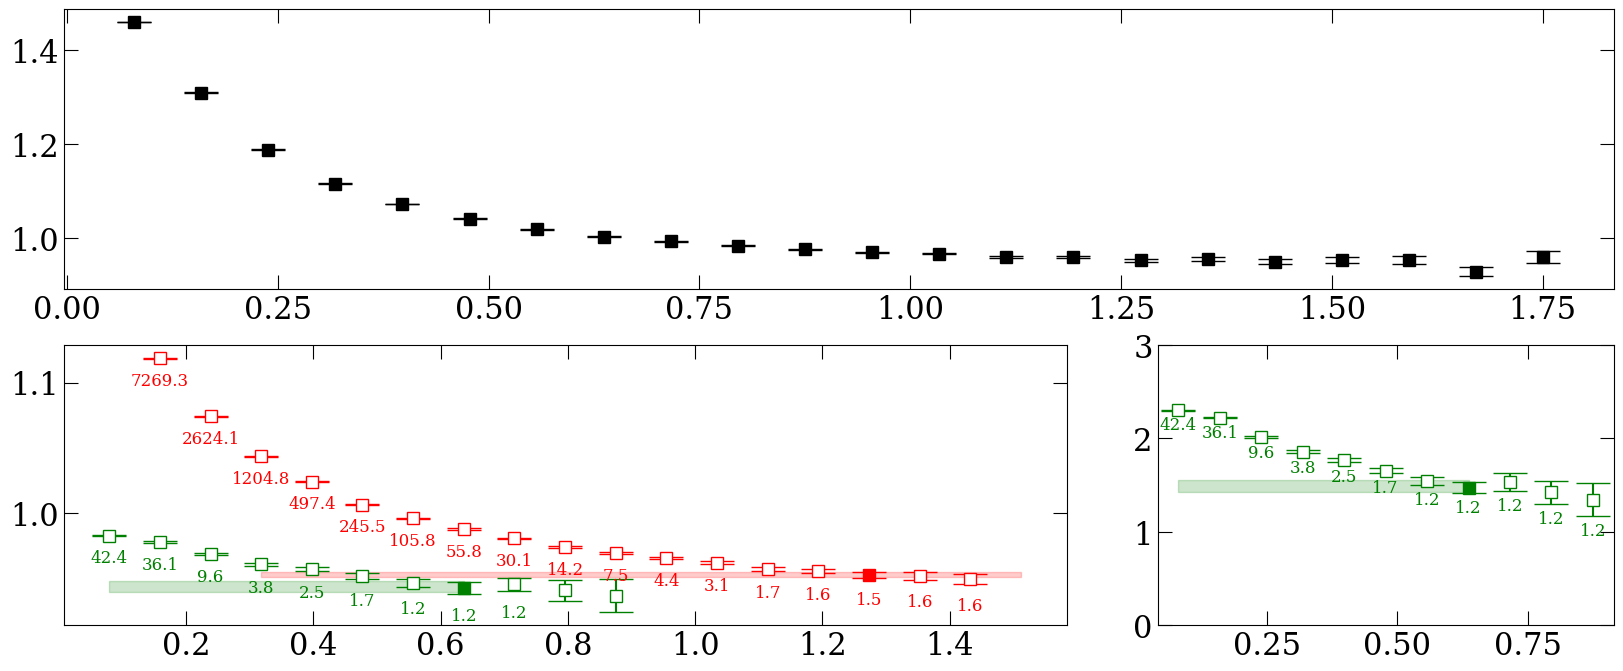

In [ ]:
fig, axd = plt.subplot_mosaic([['f1','f1','f1'],['f2','f2','f3']],figsize=(20,8))
(ax1,ax2,ax3)=(axd[key] for key in ['f1','f2','f3'])

# ax1.set_ylim([1.1,1.5])
# ax2.set_ylim([1.1,1.3])
ax3.set_ylim([0,3])

xunit=ens2a[ens]; yunit=ens2aInv[ens]/1000
chi2Size=12

meff_mean,meff_err=yu.jackme(meff_N)
tmin,tmax=1,23
plt_x=np.arange(tmin,tmax)*xunit; plt_y=meff_mean[tmin:tmax]*yunit; plt_error=meff_err[tmin:tmax]*yunit
ax1.errorbar(plt_x,plt_y,plt_error,color='black',fmt='s')

color='r'
for i,fit in enumerate(fitress_N):
    fitmin,fitmax=fit[0]; E_mean,E_err=fit[1]; chi2R=fit[2]
    mfc=None if i==ind_N else 'white'
    plt_x=[fitmin*xunit]; plt_y=E_mean*yunit; plt_yerr=E_err*yunit
    ax2.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=mfc)
    chi2_shift=0.02
    ax2.annotate("%0.1f" %chi2R[0],(plt_x[0],(plt_y-plt_yerr-chi2_shift)[0]),color=color,size=chi2Size,ha='center')
E_mean,E_err=yu.jackme(E_N)
plt_x=np.array([4,19])*xunit; plt_y=E_mean*yunit; plt_error=E_err*yunit
print(yu.un2str(plt_y[0]*1000,plt_error[0]*1000))
ax2.fill_between(plt_x,plt_y-plt_error,plt_y+plt_error,color=color,alpha=0.2)

color='g'
for i,fit in enumerate(fitress_N2st):
    fitmin,fitmax=fit[0]; E_mean,E_err=fit[1]; chi2R=fit[2]
    mfc=None if i==ind_N2st else 'white'
    if i==ind_N2st:
        print(fitmin,fitmax)
    plt_x=[fitmin*xunit]; plt_y=E_mean[0]*yunit; plt_yerr=E_err[0]*yunit
    ax2.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=mfc)
    chi2_shift=0.02
    ax2.annotate("%0.1f" %chi2R[0],(plt_x[0],plt_y-plt_yerr-chi2_shift),color=color,size=chi2Size,ha='center')
    
    plt_x=[fitmin*xunit]; plt_y=E_mean[1]*yunit; plt_yerr=E_err[1]*yunit
    ax3.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=mfc)
    chi2_shift=200/1000
    ax3.annotate("%0.1f" %chi2R[0],(plt_x[0],plt_y-plt_yerr-chi2_
                                    ),color=color,size=chi2Size,ha='center')
    
E_mean,E_err=yu.jackme(E_N2st)
plt_x=np.array([1,8])*xunit; plt_y=E_mean[0]*yunit; plt_error=E_err[0]*yunit
print(yu.un2str(plt_y*1000,plt_error*1000))
ax2.fill_between(plt_x,plt_y-plt_error,plt_y+plt_error,color=color,alpha=0.2)
plt_x=np.array([1,8])*xunit; plt_y=E_mean[1]*yunit; plt_error=E_err[1]*yunit
ax3.fill_between(plt_x,plt_y-plt_error,plt_y+plt_error,color=color,alpha=0.2)


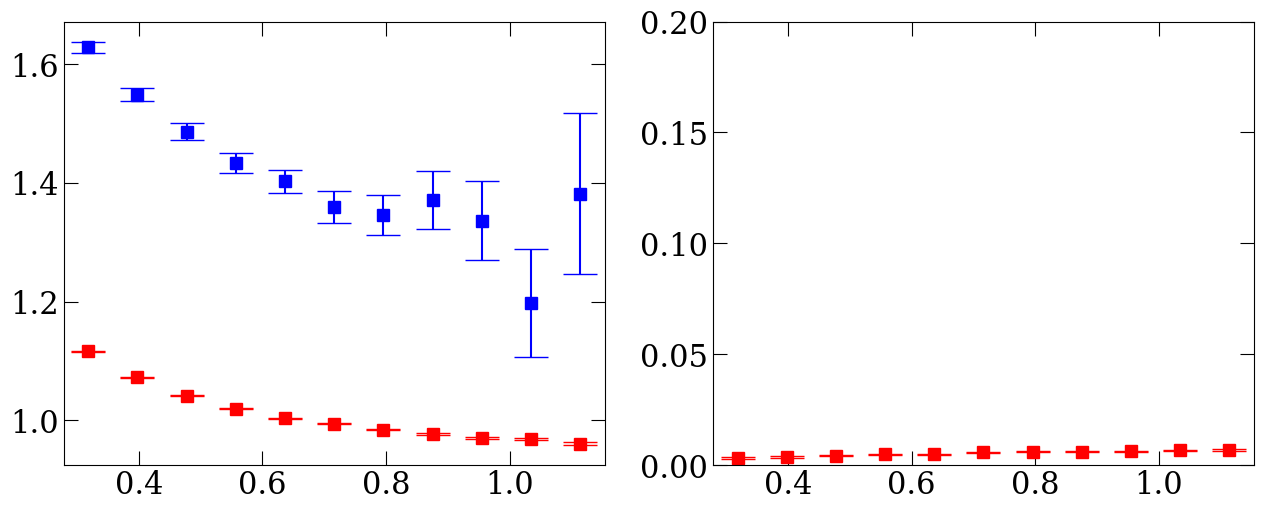

In [14]:
diags=yu.diags_all
ops=['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;N0sgm0,a;l1;p,sgm']
dat=get2ptMat(ops,diags=diags)

GEVP_t0=3
def func(c2ptM):
    evals,evecs=yu.GEVP(c2ptM,GEVP_t0)
    # for eval in evals:
    #     print(eval,eval[0]>eval[1])
    # 1/0
    En=np.log(evals/np.roll(evals,-1,axis=0))
    t=evecs[:,:,0]
    evecs=np.abs(evecs/t[:,:,None])
    res=np.concatenate([En,evecs[:,:,1]],axis=1)
    res=np.real(res)
    return res

resGEVP=yu.jackmap(func,dat)
mean,err=yu.jackme(resGEVP)

fig, axs = yu.getFigAxs(1,2,scale=1,sharex=True)
# axs[0,0].set_ylim([0,2*1e5])
xunit=ens2a[ens]

ax=axs[0,0]
tmin=GEVP_t0+1; tmax=15; yunit=ens2aInv[ens]/1000
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax,0]*yunit; plt_yerr=err[tmin:tmax,0]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='r')
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax,1]*yunit; plt_yerr=err[tmin:tmax,1]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

# tmean,terr=yu.jackme(E_N2st[:,0]+E_sgm[:,0])
# plt_x=np.array([1,15])*xunit; plt_y=tmean*yunit; plt_error=terr*yunit
# ax.fill_between(plt_x,plt_y-plt_error,plt_y+plt_error,color='orange',alpha=0.2)

ax=axs[0,1]
tmin=GEVP_t0+1; tmax=15; yunit=1
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax,2]*yunit; plt_yerr=err[tmin:tmax,2]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='r')
# plt_x=range(tmin,tmax); plt_y=mean[tmin:tmax,3]*yunit; plt_yerr=err[tmin:tmax,3]*yunit
# ax.errorbar(plt_x,plt_y,plt_yerr,color='b')
ax.set_ylim(0,0.2)

None

In [15]:
xlim_rainbow=[-0.6,0.6]
xticks_rainbow=[-0.6,-0.3,0,0.3,0.6]
xlabel_rainbow=r'$t_{\mathrm{ins}}-t_{\mathrm{s}}/2$ [fm]'
xlim_fit=[0,0.6]
xticks_fit=[0.1,0.3,0.5,0.7]
xlabel_fit=r'$t_{\mathrm{ins,min}}$ [fm]'

In [28]:
tfs

[8, 10, 12, 14, 16, 18, 20]

1st GEVP (14, 5) [1.35771536]
2st GEVP (10, 5) [1.99110306]
2st noGEVP (16, 5) [2.00034914]


/tmp/ipykernel_42698/3902215786.py:268: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower left')
/tmp/ipykernel_42698/3902215786.py:315: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower left')


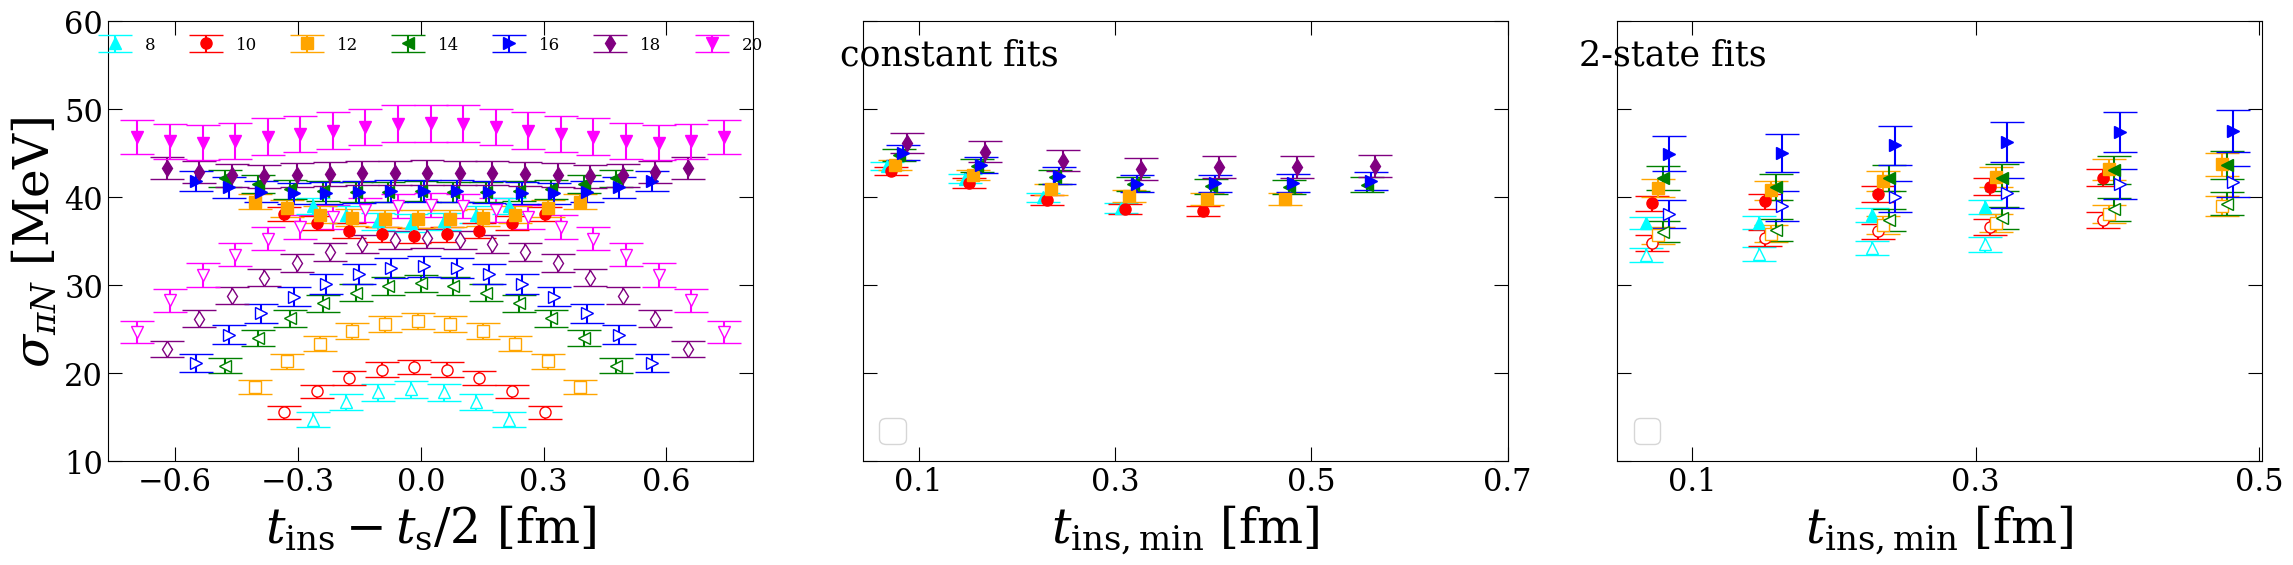

In [33]:
diags=yu.diags_all #- {'B3pt','W3pt','Z3pt'}
# diags=yu.diags_jLoopless
ops=['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;N0sgm0,a;l1;p,sgm']
# ops=['g;0,0,1;G1;a;l1;p','g;0,0,1;G1;N1sgm0,a;l1;p,sgm']

c2ptM=get2ptMat(ops)
c3ptM=[get3ptMat(ops,ops,f'id_j+_{tf}',diags=diags) for tf in tfs]

ratio=[np.real(c3ptM[i_tf][:,:,0,0])/np.real(c2ptM[:,tf,0,0][:,None]) for i_tf,tf in enumerate(tfs)]

# s0=1
# ratioSum=[np.sum(ele[:,s0:-s0],axis=1) for ele in ratio]
# ratioSumDif=[(ratioSum[i+1]-ratioSum[i])/2  for i in range(len(ratioSum)-1)]

# fitfunc=lambda x: np.array([x[0]+x[1]*tf for tf in tfs])
# pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,np.transpose(ratioSum),[-100,50])
# print(np.mean(chi2_jk)/Ndof)

GEVP_t0=6
def func(c2ptM):
    evals,evecs=yu.GEVP(c2ptM,GEVP_t0)
    En=np.log(evals/np.roll(evals,-1,axis=0))
    t=evecs[:,:,0]
    evecs=np.abs(evecs/t[:,:,None])
    res=np.concatenate([En,evecs[:,:,1]],axis=1)
    res=np.real(res)
    return res
resGEVP=yu.jackmap(func,c2ptM)

GEVP_t=14
evec_global=np.array([np.mean(resGEVP[:,GEVP_t,2])])
# evec_global=np.array([0])
def get(i_tf):
    tf=tfs[i_tf]
    # evec=np.array([np.mean(resGEVP[:,16,2])])
    evec=evec_global
    # evec=resGEVP[:,14,2]
    c3pt=c3ptM[i_tf][:,:,0,0]+ evec[:,None]*c3ptM[i_tf][:,:,0,1] + evec[:,None]*c3ptM[i_tf][:,:,1,0]
    c2pt=c2ptM[:,tf,0,0] + evec*c2ptM[:,tf,0,1] + evec*c2ptM[:,tf,1,0] + evec**2*c2ptM[:,tf,1,1] *0
    return np.real(c3pt)/np.real(c2pt)[:,None]

ratioGEVP=[get(i_tf) for i_tf,tf in enumerate(tfs)]

# ratioGEVPSum=[np.sum(ele[:,s0:-s0],axis=1) for ele in ratioGEVP]
# ratioGEVPSumDif=[(ratioGEVPSum[i+1]-ratioGEVPSum[i])/2 for i in range(len(ratioGEVPSum)-1)]

# parsGEVP_jk,chi2GEVP_jk,NdofGEVP=yu.jackfit(fitfunc,np.transpose(ratioGEVPSum),[-100,50])
# print(np.mean(chi2GEVP_jk)/NdofGEVP)


fits=[]; fitress=[]
for tfmin in [8,10,12,14,16,18]:
    for tcmin in [1,2,3,4,5,6,7]:
        if tfmin+1-tcmin <= tcmin:
            continue        
        i_tfs_fit=[i_tf for i_tf,tf in enumerate(tfs) if tf>=tfmin]
        tfs_fit=[tf for tf in tfs if tf>=tfmin]
        tcs_fit={tf:np.arange(tcmin,tf//2+1) for tf in tfs_fit}

        ratioGEVP_fit=np.concatenate([ratioGEVP[i_tf][:,tcs_fit[tfs[i_tf]]] for i_tf in i_tfs_fit],axis=1)
        fitfunc=lambda pars: np.zeros(ratioGEVP_fit.shape[1]) + pars[0]
        
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,ratioGEVP_fit,[20])
        
        fits.append([pars_jk,chi2_jk,Ndof])
        
        pars_mean,pars_err=yu.jackme(pars_jk)
        chi2_mean,chi2_err=yu.jackme(chi2_jk)
        
        fitress.append([(tfmin,tcmin),(pars_mean,pars_err),chi2_mean/Ndof])

evec=evec_global
c2ptGEVP=np.real(c2ptM[:,:,0,0] + evec*c2ptM[:,:,0,1] + evec*c2ptM[:,:,1,0])
c3ptGEVP={tf:np.real(c3ptM[i_tf][:,:,0,0]+ evec[:,None]*c3ptM[i_tf][:,:,0,1] + evec[:,None]*c3ptM[i_tf][:,:,1,0]) for i_tf,tf in enumerate(tfs)}

func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C3pt_2st=lambda tf,tc,E0a,E0b,a00,dE1a,dE1b,ra01,ra10,ra11: a00*np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(1 + ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc)) \
    if a00!=0 else np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc))


tmin2pt=5
tmax2pt=23
# pars0=[0.5,1e-7,0.3,0.8,20,0.1,0,0.4] # full
pars0=[0.5,1e-7,0.3,0.8,20,0.1,0] # dE1=dE1_3pt
# pars0=[0.5,1e-7,0.3,0.8,20,0.1,0.3] # no ra11
# pars0=[0.5,1e-7,0.3,0.8,20,0.1] # no ra11, dE1=dE1_3pt

fits_2st=[]; fitress_2st=[]
for tfmin in [8,10,12,14,16]:
    for tcmin in [1,2,3,4,5,6]:
        if tfmin+1-tcmin <= tcmin:
            continue        
        i_tfs_fit=[i_tf for i_tf,tf in enumerate(tfs) if tf>=tfmin]
        tfs_fit=[tf for tf in tfs if tf>=tfmin]
        tcs_fit={tf:np.arange(tcmin,tf//2+1) for tf in tfs_fit}
        tfs2pt_fit=np.arange(tmin2pt,tmax2pt+1)
        
        c2ptGEVP_fit=c2ptGEVP[:,tmin2pt:tmax2pt+1]
        c3ptGEVP_fit=np.concatenate([c3ptGEVP[tf][:,tcs_fit[tf]] for tf in tfs_fit],axis=1)
        cGEVP_fit=np.concatenate([c2ptGEVP_fit,c3ptGEVP_fit],axis=1)
        def fitfunc(pars):
            # # full
            # E0,c0,dE1,rc1,g,ra01,ra11,dE1_3pt=pars
            # t2pt=func_C2pt_2st(tfs2pt_fit,E0,c0,dE1,rc1)
            # t3pt=[func_C3pt_2st(tf,tcs_fit[tf],E0,E0,g*c0,dE1_3pt,dE1_3pt,ra01,ra01,ra11) for tf in tfs_fit]
            
            # dE1=dE1_3pt
            E0,c0,dE1,rc1,g,ra01,ra11=pars
            t2pt=func_C2pt_2st(tfs2pt_fit,E0,c0,dE1,rc1)
            t3pt=[func_C3pt_2st(tf,tcs_fit[tf],E0,E0,g*c0,dE1,dE1,ra01,ra01,ra11) for tf in tfs_fit]
            
            # # no ra11
            # E0,c0,dE1,rc1,g,ra01,dE1_3pt=pars
            # t2pt=func_C2pt_2st(tfs2pt_fit,E0,c0,dE1,rc1)
            # t3pt=[func_C3pt_2st(tf,tcs_fit[tf],E0,E0,g*c0,dE1_3pt,dE1_3pt,ra01,ra01,0) for tf in tfs_fit]
            
            # # no ra11, dE1=dE1_3pt
            # E0,c0,dE1,rc1,g,ra01=pars
            # t2pt=func_C2pt_2st(tfs2pt_fit,E0,c0,dE1,rc1)
            # t3pt=[func_C3pt_2st(tf,tcs_fit[tf],E0,E0,g*c0,dE1,dE1,ra01,ra01,0) for tf in tfs_fit]
            
            t=[t2pt]+t3pt
            return np.concatenate(t)
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,cGEVP_fit,pars0)
        fits_2st.append([pars_jk,chi2_jk,Ndof])
        
        pars_mean,pars_err=yu.jackme(pars_jk)
        chi2_mean,chi2_err=yu.jackme(chi2_jk)
        
        pars0=pars_mean
        
        fitress_2st.append([(tfmin,tcmin),(pars_mean,pars_err),chi2_mean/Ndof])


tmin2pt=5
tmax2pt=23
# pars0=[0.5,1e-7,0.3,0.8,20,0.1,0,0.4] # full
pars0=[0.5,1e-7,0.3,0.8,20,0.1,0] # dE1=dE1_3pt
# pars0=[0.5,1e-7,0.3,0.8,20,0.1,0.3] # no ra11
# pars0=[0.5,1e-7,0.3,0.8,20,0.1] # no ra11, dE1=dE1_3pt

evec=np.array([0])
c2ptGEVP=np.real(c2ptM[:,:,0,0] + evec*c2ptM[:,:,0,1] + evec*c2ptM[:,:,1,0])
c3ptGEVP={tf:np.real(c3ptM[i_tf][:,:,0,0]+ evec[:,None]*c3ptM[i_tf][:,:,0,1] + evec[:,None]*c3ptM[i_tf][:,:,1,0]) for i_tf,tf in enumerate(tfs)}

fits_2st_noGEVP=[]; fitress_2st_noGEVP=[]
for tfmin in [8,10,12,14,16]:
    for tcmin in [1,2,3,4,5,6]:
        if tfmin+1-tcmin <= tcmin:
            continue        
        i_tfs_fit=[i_tf for i_tf,tf in enumerate(tfs) if tf>=tfmin]
        tfs_fit=[tf for tf in tfs if tf>=tfmin]
        tcs_fit={tf:np.arange(tcmin,tf//2+1) for tf in tfs_fit}
        tfs2pt_fit=np.arange(tmin2pt,tmax2pt+1)
        
        c2ptGEVP_fit=c2ptGEVP[:,tmin2pt:tmax2pt+1]
        c3ptGEVP_fit=np.concatenate([c3ptGEVP[tf][:,tcs_fit[tf]] for tf in tfs_fit],axis=1)
        cGEVP_fit=np.concatenate([c2ptGEVP_fit,c3ptGEVP_fit],axis=1)
        def fitfunc(pars):
            # # full
            # E0,c0,dE1,rc1,g,ra01,ra11,dE1_3pt=pars
            # t2pt=func_C2pt_2st(tfs2pt_fit,E0,c0,dE1,rc1)
            # t3pt=[func_C3pt_2st(tf,tcs_fit[tf],E0,E0,g*c0,dE1_3pt,dE1_3pt,ra01,ra01,ra11) for tf in tfs_fit]
            
            # dE1=dE1_3pt
            E0,c0,dE1,rc1,g,ra01,ra11=pars
            t2pt=func_C2pt_2st(tfs2pt_fit,E0,c0,dE1,rc1)
            t3pt=[func_C3pt_2st(tf,tcs_fit[tf],E0,E0,g*c0,dE1,dE1,ra01,ra01,ra11) for tf in tfs_fit]
            
            # # no ra11
            # E0,c0,dE1,rc1,g,ra01,dE1_3pt=pars
            # t2pt=func_C2pt_2st(tfs2pt_fit,E0,c0,dE1,rc1)
            # t3pt=[func_C3pt_2st(tf,tcs_fit[tf],E0,E0,g*c0,dE1_3pt,dE1_3pt,ra01,ra01,0) for tf in tfs_fit]
            
            # # no ra11, dE1=dE1_3pt
            # E0,c0,dE1,rc1,g,ra01=pars
            # t2pt=func_C2pt_2st(tfs2pt_fit,E0,c0,dE1,rc1)
            # t3pt=[func_C3pt_2st(tf,tcs_fit[tf],E0,E0,g*c0,dE1,dE1,ra01,ra01,0) for tf in tfs_fit]
            
            t=[t2pt]+t3pt
            return np.concatenate(t)
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,cGEVP_fit,pars0)
        fits_2st_noGEVP.append([pars_jk,chi2_jk,Ndof])
        
        pars_mean,pars_err=yu.jackme(pars_jk)
        chi2_mean,chi2_err=yu.jackme(chi2_jk)
        
        pars0=pars_mean
        
        fitress_2st_noGEVP.append([(tfmin,tcmin),(pars_mean,pars_err),chi2_mean/Ndof])

fig, axs = yu.getFigAxs(1,3,sharey=True)
# colorMap_rainbow={('noGEVP',10):'green',('noGEVP',12):'blue',('noGEVP',14):'purple',('noGEVP',16):'brown',('noGEVP',18):'brown',\
#     ('GEVP',10):'yellow',('GEVP',12):'orange',('GEVP',14):'red',('GEVP',16):'pink',('GEVP',18:'brown')}
colorMap_rainbow={('noGEVP',8):'cyan',('noGEVP',10):'r',('noGEVP',12):'orange',('noGEVP',14):'green',('noGEVP',16):'blue',('noGEVP',18):'purple',('noGEVP',20):'magenta',\
    ('GEVP',8):'cyan',('GEVP',10):'r',('GEVP',12):'orange',('GEVP',14):'green',('GEVP',16):'blue',('GEVP',18):'purple',('GEVP',20):'magenta'}
markerMap={8:'^',10:'o',12:'s',14:'<',16:'>',18:'d',20:'v'}
xunit=ens2a[ens]; yunit=ens2amu[ens]*ens2aInv[ens]


case='noGEVP'
mfc={'noGEVP':'white','GEVP':None}[case]

ax=axs[0,0]
for i_tf,tf in enumerate(tfs):
    color=colorMap_rainbow[(case,tf)]
    marker=markerMap[tf]
    mean,err=yu.jackme(ratio[i_tf])
    plt_x=(np.arange(1 - tf//2,tf//2)+(tf-14)*0.05)*xunit; plt_y=mean[1:tf]*yunit; plt_yerr=err[1:tf]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=mfc,marker=marker) 
# ax=axs[0,1]
# for i_tf,tf in enumerate(tfs[1:]):
#     color=colorMap_rainbow[(case,tf)]
#     mean,err=yu.jackme(ratioSumDif[i_tf])
#     plt_x=np.array([tf])*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
#     ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=mfc)

# mean,err=yu.jackme(pars_jk)
# plt_x=np.array([11,14])*xunit; plt_y=mean[1]*yunit; plt_error=err[1]*yunit
# ax.fill_between(plt_x,plt_y-plt_error,plt_y+plt_error,color=color,alpha=0.2)


case='GEVP'
mfc={'noGEVP':'white','GEVP':None}[case]
ax=axs[0,0]
for i_tf,tf in enumerate(tfs):
    color=colorMap_rainbow[(case,tf)]
    marker=markerMap[tf]
    mean,err=yu.jackme(ratioGEVP[i_tf])
    plt_x=(np.arange(1 - tf//2,tf//2)+(tf-14)*0.05)*xunit; plt_y=mean[1:tf]*yunit; plt_yerr=err[1:tf]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=mfc,marker=marker,label=f'{tf}')
    
ax.legend(loc='upper center',ncol=len(tfs),fontsize=12,framealpha=0)
    
ax=axs[0,1]
# for i_tf,tf in enumerate(tfs[1:]):
#     color=colorMap_rainbow[(case,tf)]
#     mean,err=yu.jackme(ratioGEVPSumDif[i_tf])
#     plt_x=np.array([tf])*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
#     ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=mfc)
    
# mean,err=yu.jackme(parsGEVP_jk)
# plt_x=np.array([12,19])*xunit; plt_y=mean[1]*yunit; plt_error=err[1]*yunit
# ax.fill_between(plt_x,plt_y-plt_error,plt_y+plt_error,color=color,alpha=0.2)

pars_jk,props_jk=yu.jackMA(fits)
ind=np.argmax(yu.jackme(props_jk)[0])
for i,fitres in enumerate(fitress):
    (tfmin,tcmin)=fitres[0]
    (pars_mean,pars_err)=fitres[1]
    chi2R=fitres[2]
    
    color=colorMap_rainbow[(case,tfmin)]
    marker=markerMap[tfmin]
    shift={8:-0.3,10:-0.2,12:-0.1,14:0,16:0.1,18:0.2}[tfmin]/2
    mfc=None
    
    if i == ind:
        # mfc='white'
        print('1st GEVP',(tfmin,tcmin),chi2R)
    
    plt_x=np.array([tcmin+shift])*xunit; plt_y=pars_mean[0]*yunit; plt_yerr=pars_err[0]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=mfc,marker=marker)

mean,err=yu.jackme(pars_jk)
plt_x=np.array([0,8])*xunit; plt_y=mean*yunit; plt_error=err*yunit
# ax.fill_between(plt_x,plt_y-plt_error,plt_y+plt_error,color='red',alpha=0.2,label=f'{yu.un2str(mean[0]*yunit,err[0]*yunit,1)}')
ax.legend(loc='lower left')

ax=axs[0,2]
pars_jk,props_jk=yu.jackMA(fits_2st)
ind=np.argmax(yu.jackme(props_jk)[0])
for i,fitres in enumerate(fitress_2st):
    (tfmin,tcmin)=fitres[0]
    (pars_mean,pars_err)=fitres[1]
    chi2R=fitres[2]
    
    color=colorMap_rainbow[(case,tfmin)]
    marker=markerMap[tfmin]
    shift={8:-0.3,10:-0.2,12:-0.1,14:0,16:0.1,18:0.2}[tfmin]/2
    mfc=None
    
    if i == ind:
        # mfc='white'
        print('2st GEVP',(tfmin,tcmin),chi2R)
    
    plt_x=np.array([tcmin+shift])*xunit; plt_y=pars_mean[4]*yunit; plt_yerr=pars_err[4]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=mfc,marker=marker)
mean,err=yu.jackme(pars_jk)
plt_x=np.array([0,6.5])*xunit; plt_y=mean[4]*yunit; plt_error=err[4]*yunit
# ax.fill_between(plt_x,plt_y-plt_error,plt_y+plt_error,color='red',alpha=0.2,label=f'{yu.un2str(mean[4]*yunit,err[4]*yunit,2)}, with '+r'$\mathcal{J}_{N\sigma}$')

pars_jk,props_jk=yu.jackMA(fits_2st_noGEVP)
ind=np.argmax(yu.jackme(props_jk)[0])
for i,fitres in enumerate(fitress_2st_noGEVP):
    (tfmin,tcmin)=fitres[0]
    (pars_mean,pars_err)=fitres[1]
    chi2R=fitres[2]
    
    color=colorMap_rainbow[(case,tfmin)]
    marker=markerMap[tfmin]
    shift={8:-0.3,10:-0.2,12:-0.1,14:0,16:0.1,18:0.2}[tfmin]/2
    mfc='white'
    
    if i == ind:
        # mfc=None
        print('2st noGEVP',(tfmin,tcmin),chi2R)
    
    plt_x=np.array([tcmin+shift])*xunit; plt_y=pars_mean[4]*yunit; plt_yerr=pars_err[4]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=mfc,marker=marker)
mean,err=yu.jackme(pars_jk)
plt_x=np.array([0.5,7])*xunit; plt_y=mean[4]*yunit; plt_error=err[4]*yunit
# ax.fill_between(plt_x,plt_y-plt_error,plt_y+plt_error,color='blue',alpha=0.2,label=f'{yu.un2str(mean[4]*yunit,err[4]*yunit,2)}, w/o '+r'$\mathcal{J}_{N\sigma}$')

ax.legend(loc='lower left')

axs[0,0].set_ylim([10,60])
    
# axs[0,0].set_ylim([15,65])
# axs[0,0].axhline(40,linestyle='--')
# axs[0,0].axhline(60,linestyle='--')

axs[0,0].set_xlabel(xlabel_rainbow,fontsize=35)
axs[0,0].set_xticks(xticks_rainbow)

axs[0,1].set_xlabel(xlabel_fit,fontsize=35)
axs[0,1].set_xticks(xticks_fit)
axs[0,1].text(0.02,55,'constant fits',fontsize=25)

axs[0,2].set_xlabel(xlabel_fit,fontsize=35)
axs[0,2].set_xticks(xticks_fit[:-1])
axs[0,2].text(0.02,55,'2-state fits',fontsize=25)

axs[0,0].set_ylabel(r'$\sigma_{\pi N}$ [MeV]',fontsize=35)

plt.tight_layout()
plt.savefig(f'fig/sgm_cB64.pdf')
# plt.close()

1st GEVP (14, 4) [1.73104295]
2st GEVP (12, 4) [2.2197025]
2st noGEVP (16, 4) [2.27036737]


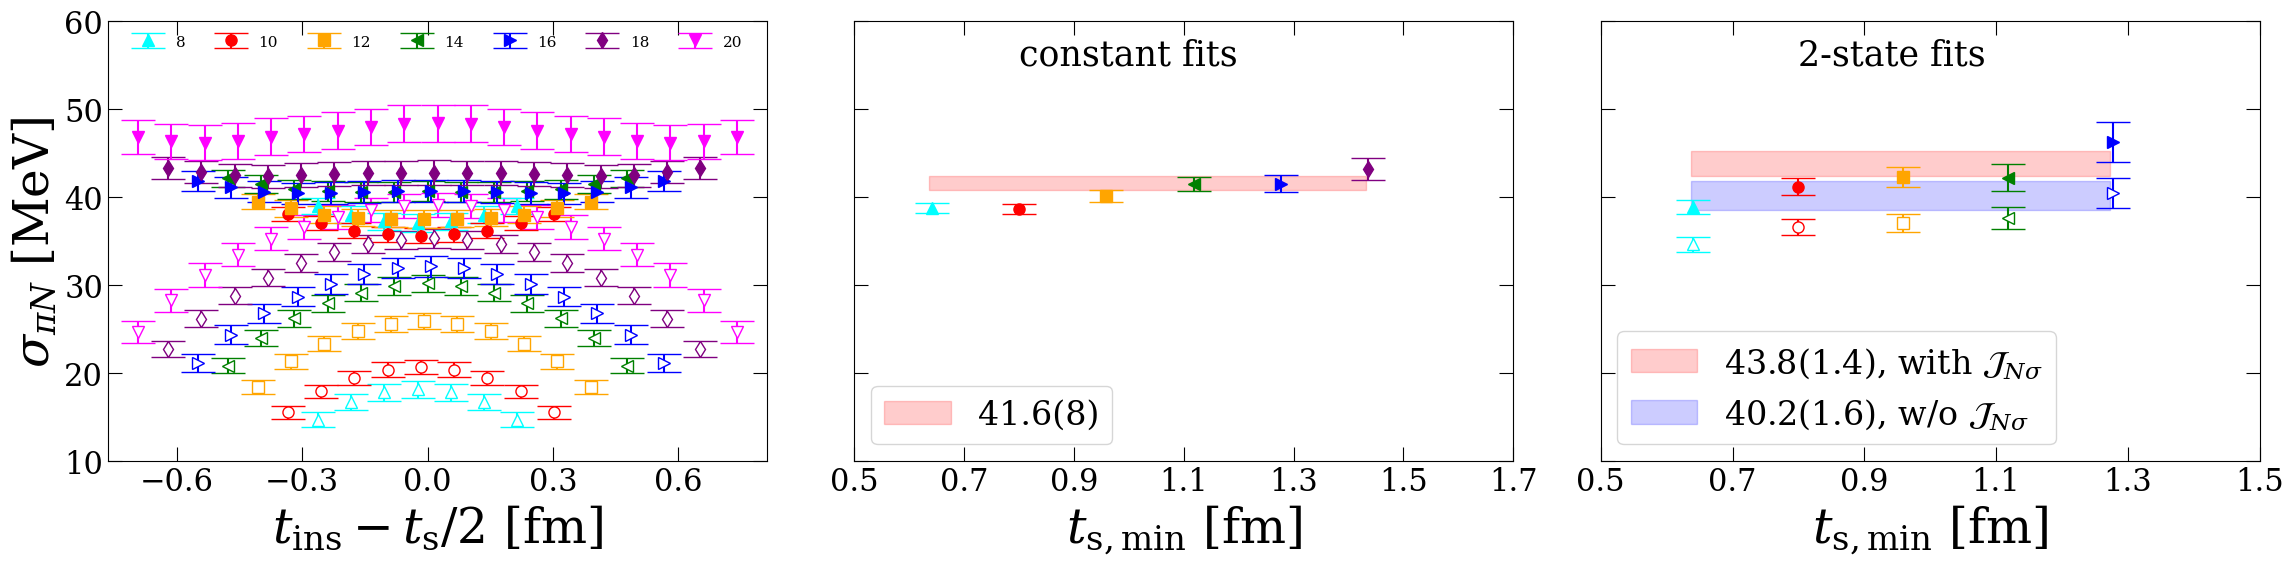

In [50]:
# vesus t_f

xlim_rainbow=[-0.6,0.6]
xticks_rainbow=[-0.6,-0.3,0,0.3,0.6]
xlabel_rainbow=r'$t_{\mathrm{ins}}-t_{\mathrm{s}}/2$ [fm]'
# xlim_fit=[0.6,1.6]
xticks_fit=[0.5,0.7,0.9,1.1,1.3,1.5,1.7]
xlabel_fit=r'$t_{\mathrm{s,min}}$ [fm]'

diags=yu.diags_all #- {'B3pt','W3pt','Z3pt'}
# diags=yu.diags_jLoopless
ops=['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;N0sgm0,a;l1;p,sgm']
# ops=['g;0,0,1;G1;a;l1;p','g;0,0,1;G1;N1sgm0,a;l1;p,sgm']

c2ptM=get2ptMat(ops)
c3ptM=[get3ptMat(ops,ops,f'id_j+_{tf}',diags=diags) for tf in tfs]

ratio=[np.real(c3ptM[i_tf][:,:,0,0])/np.real(c2ptM[:,tf,0,0][:,None]) for i_tf,tf in enumerate(tfs)]

# s0=1
# ratioSum=[np.sum(ele[:,s0:-s0],axis=1) for ele in ratio]
# ratioSumDif=[(ratioSum[i+1]-ratioSum[i])/2  for i in range(len(ratioSum)-1)]

# fitfunc=lambda x: np.array([x[0]+x[1]*tf for tf in tfs])
# pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,np.transpose(ratioSum),[-100,50])
# print(np.mean(chi2_jk)/Ndof)

GEVP_t0=6
def func(c2ptM):
    evals,evecs=yu.GEVP(c2ptM,GEVP_t0)
    En=np.log(evals/np.roll(evals,-1,axis=0))
    t=evecs[:,:,0]
    evecs=np.abs(evecs/t[:,:,None])
    res=np.concatenate([En,evecs[:,:,1]],axis=1)
    res=np.real(res)
    return res
resGEVP=yu.jackmap(func,c2ptM)

GEVP_t=14
evec_global=np.array([np.mean(resGEVP[:,GEVP_t,2])])
# evec_global=np.array([0])
def get(i_tf):
    tf=tfs[i_tf]
    # evec=np.array([np.mean(resGEVP[:,16,2])])
    evec=evec_global
    # evec=resGEVP[:,14,2]
    c3pt=c3ptM[i_tf][:,:,0,0]+ evec[:,None]*c3ptM[i_tf][:,:,0,1] + evec[:,None]*c3ptM[i_tf][:,:,1,0]
    c2pt=c2ptM[:,tf,0,0] + evec*c2ptM[:,tf,0,1] + evec*c2ptM[:,tf,1,0] + evec**2*c2ptM[:,tf,1,1] *0
    return np.real(c3pt)/np.real(c2pt)[:,None]

ratioGEVP=[get(i_tf) for i_tf,tf in enumerate(tfs)]

# ratioGEVPSum=[np.sum(ele[:,s0:-s0],axis=1) for ele in ratioGEVP]
# ratioGEVPSumDif=[(ratioGEVPSum[i+1]-ratioGEVPSum[i])/2 for i in range(len(ratioGEVPSum)-1)]

# parsGEVP_jk,chi2GEVP_jk,NdofGEVP=yu.jackfit(fitfunc,np.transpose(ratioGEVPSum),[-100,50])
# print(np.mean(chi2GEVP_jk)/NdofGEVP)

tcmins=[1,2,3,4,5,6,7]
tcmins=[4]

fits=[]; fitress=[]
for tfmin in [8,10,12,14,16,18]:
    for tcmin in tcmins:
        if tfmin+1-tcmin <= tcmin:
            continue        
        i_tfs_fit=[i_tf for i_tf,tf in enumerate(tfs) if tf>=tfmin]
        tfs_fit=[tf for tf in tfs if tf>=tfmin]
        tcs_fit={tf:np.arange(tcmin,tf//2+1) for tf in tfs_fit}

        ratioGEVP_fit=np.concatenate([ratioGEVP[i_tf][:,tcs_fit[tfs[i_tf]]] for i_tf in i_tfs_fit],axis=1)
        fitfunc=lambda pars: np.zeros(ratioGEVP_fit.shape[1]) + pars[0]
        
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,ratioGEVP_fit,[20])
        
        fits.append([pars_jk,chi2_jk,Ndof])
        
        pars_mean,pars_err=yu.jackme(pars_jk)
        chi2_mean,chi2_err=yu.jackme(chi2_jk)
        
        fitress.append([(tfmin,tcmin),(pars_mean,pars_err),chi2_mean/Ndof])

evec=evec_global
c2ptGEVP=np.real(c2ptM[:,:,0,0] + evec*c2ptM[:,:,0,1] + evec*c2ptM[:,:,1,0])
c3ptGEVP={tf:np.real(c3ptM[i_tf][:,:,0,0]+ evec[:,None]*c3ptM[i_tf][:,:,0,1] + evec[:,None]*c3ptM[i_tf][:,:,1,0]) for i_tf,tf in enumerate(tfs)}

func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C3pt_2st=lambda tf,tc,E0a,E0b,a00,dE1a,dE1b,ra01,ra10,ra11: a00*np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(1 + ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc)) \
    if a00!=0 else np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc))


tmin2pt=5
tmax2pt=23
# pars0=[0.5,1e-7,0.3,0.8,20,0.1,0,0.4] # full
pars0=[0.5,1e-7,0.3,0.8,20,0.1,0] # dE1=dE1_3pt
# pars0=[0.5,1e-7,0.3,0.8,20,0.1,0.3] # no ra11
# pars0=[0.5,1e-7,0.3,0.8,20,0.1] # no ra11, dE1=dE1_3pt

fits_2st=[]; fitress_2st=[]
for tfmin in [8,10,12,14,16]:
    for tcmin in tcmins:
        if tfmin+1-tcmin <= tcmin:
            continue        
        i_tfs_fit=[i_tf for i_tf,tf in enumerate(tfs) if tf>=tfmin]
        tfs_fit=[tf for tf in tfs if tf>=tfmin]
        tcs_fit={tf:np.arange(tcmin,tf//2+1) for tf in tfs_fit}
        tfs2pt_fit=np.arange(tmin2pt,tmax2pt+1)
        
        c2ptGEVP_fit=c2ptGEVP[:,tmin2pt:tmax2pt+1]
        c3ptGEVP_fit=np.concatenate([c3ptGEVP[tf][:,tcs_fit[tf]] for tf in tfs_fit],axis=1)
        cGEVP_fit=np.concatenate([c2ptGEVP_fit,c3ptGEVP_fit],axis=1)
        def fitfunc(pars):
            # # full
            # E0,c0,dE1,rc1,g,ra01,ra11,dE1_3pt=pars
            # t2pt=func_C2pt_2st(tfs2pt_fit,E0,c0,dE1,rc1)
            # t3pt=[func_C3pt_2st(tf,tcs_fit[tf],E0,E0,g*c0,dE1_3pt,dE1_3pt,ra01,ra01,ra11) for tf in tfs_fit]
            
            # dE1=dE1_3pt
            E0,c0,dE1,rc1,g,ra01,ra11=pars
            t2pt=func_C2pt_2st(tfs2pt_fit,E0,c0,dE1,rc1)
            t3pt=[func_C3pt_2st(tf,tcs_fit[tf],E0,E0,g*c0,dE1,dE1,ra01,ra01,ra11) for tf in tfs_fit]
            
            # # no ra11
            # E0,c0,dE1,rc1,g,ra01,dE1_3pt=pars
            # t2pt=func_C2pt_2st(tfs2pt_fit,E0,c0,dE1,rc1)
            # t3pt=[func_C3pt_2st(tf,tcs_fit[tf],E0,E0,g*c0,dE1_3pt,dE1_3pt,ra01,ra01,0) for tf in tfs_fit]
            
            # # no ra11, dE1=dE1_3pt
            # E0,c0,dE1,rc1,g,ra01=pars
            # t2pt=func_C2pt_2st(tfs2pt_fit,E0,c0,dE1,rc1)
            # t3pt=[func_C3pt_2st(tf,tcs_fit[tf],E0,E0,g*c0,dE1,dE1,ra01,ra01,0) for tf in tfs_fit]
            
            t=[t2pt]+t3pt
            return np.concatenate(t)
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,cGEVP_fit,pars0)
        fits_2st.append([pars_jk,chi2_jk,Ndof])
        
        pars_mean,pars_err=yu.jackme(pars_jk)
        chi2_mean,chi2_err=yu.jackme(chi2_jk)
        
        pars0=pars_mean
        
        fitress_2st.append([(tfmin,tcmin),(pars_mean,pars_err),chi2_mean/Ndof])


tmin2pt=5
tmax2pt=23
# pars0=[0.5,1e-7,0.3,0.8,20,0.1,0,0.4] # full
pars0=[0.5,1e-7,0.3,0.8,20,0.1,0] # dE1=dE1_3pt
# pars0=[0.5,1e-7,0.3,0.8,20,0.1,0.3] # no ra11
# pars0=[0.5,1e-7,0.3,0.8,20,0.1] # no ra11, dE1=dE1_3pt

evec=np.array([0])
c2ptGEVP=np.real(c2ptM[:,:,0,0] + evec*c2ptM[:,:,0,1] + evec*c2ptM[:,:,1,0])
c3ptGEVP={tf:np.real(c3ptM[i_tf][:,:,0,0]+ evec[:,None]*c3ptM[i_tf][:,:,0,1] + evec[:,None]*c3ptM[i_tf][:,:,1,0]) for i_tf,tf in enumerate(tfs)}

fits_2st_noGEVP=[]; fitress_2st_noGEVP=[]
for tfmin in [8,10,12,14,16]:
    for tcmin in tcmins:
        if tfmin+1-tcmin <= tcmin:
            continue        
        i_tfs_fit=[i_tf for i_tf,tf in enumerate(tfs) if tf>=tfmin]
        tfs_fit=[tf for tf in tfs if tf>=tfmin]
        tcs_fit={tf:np.arange(tcmin,tf//2+1) for tf in tfs_fit}
        tfs2pt_fit=np.arange(tmin2pt,tmax2pt+1)
        
        c2ptGEVP_fit=c2ptGEVP[:,tmin2pt:tmax2pt+1]
        c3ptGEVP_fit=np.concatenate([c3ptGEVP[tf][:,tcs_fit[tf]] for tf in tfs_fit],axis=1)
        cGEVP_fit=np.concatenate([c2ptGEVP_fit,c3ptGEVP_fit],axis=1)
        def fitfunc(pars):
            # # full
            # E0,c0,dE1,rc1,g,ra01,ra11,dE1_3pt=pars
            # t2pt=func_C2pt_2st(tfs2pt_fit,E0,c0,dE1,rc1)
            # t3pt=[func_C3pt_2st(tf,tcs_fit[tf],E0,E0,g*c0,dE1_3pt,dE1_3pt,ra01,ra01,ra11) for tf in tfs_fit]
            
            # dE1=dE1_3pt
            E0,c0,dE1,rc1,g,ra01,ra11=pars
            t2pt=func_C2pt_2st(tfs2pt_fit,E0,c0,dE1,rc1)
            t3pt=[func_C3pt_2st(tf,tcs_fit[tf],E0,E0,g*c0,dE1,dE1,ra01,ra01,ra11) for tf in tfs_fit]
            
            # # no ra11
            # E0,c0,dE1,rc1,g,ra01,dE1_3pt=pars
            # t2pt=func_C2pt_2st(tfs2pt_fit,E0,c0,dE1,rc1)
            # t3pt=[func_C3pt_2st(tf,tcs_fit[tf],E0,E0,g*c0,dE1_3pt,dE1_3pt,ra01,ra01,0) for tf in tfs_fit]
            
            # # no ra11, dE1=dE1_3pt
            # E0,c0,dE1,rc1,g,ra01=pars
            # t2pt=func_C2pt_2st(tfs2pt_fit,E0,c0,dE1,rc1)
            # t3pt=[func_C3pt_2st(tf,tcs_fit[tf],E0,E0,g*c0,dE1,dE1,ra01,ra01,0) for tf in tfs_fit]
            
            t=[t2pt]+t3pt
            return np.concatenate(t)
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,cGEVP_fit,pars0)
        fits_2st_noGEVP.append([pars_jk,chi2_jk,Ndof])
        
        pars_mean,pars_err=yu.jackme(pars_jk)
        chi2_mean,chi2_err=yu.jackme(chi2_jk)
        
        pars0=pars_mean
        
        fitress_2st_noGEVP.append([(tfmin,tcmin),(pars_mean,pars_err),chi2_mean/Ndof])

fig, axs = yu.getFigAxs(1,3,sharey=True)
# colorMap_rainbow={('noGEVP',10):'green',('noGEVP',12):'blue',('noGEVP',14):'purple',('noGEVP',16):'brown',('noGEVP',18):'brown',\
#     ('GEVP',10):'yellow',('GEVP',12):'orange',('GEVP',14):'red',('GEVP',16):'pink',('GEVP',18:'brown')}
colorMap_rainbow={('noGEVP',8):'cyan',('noGEVP',10):'r',('noGEVP',12):'orange',('noGEVP',14):'green',('noGEVP',16):'blue',('noGEVP',18):'purple',('noGEVP',20):'magenta',\
    ('GEVP',8):'cyan',('GEVP',10):'r',('GEVP',12):'orange',('GEVP',14):'green',('GEVP',16):'blue',('GEVP',18):'purple',('GEVP',20):'magenta'}
markerMap={8:'^',10:'o',12:'s',14:'<',16:'>',18:'d',20:'v'}
xunit=ens2a[ens]; yunit=ens2amu[ens]*ens2aInv[ens]


case='noGEVP'
mfc={'noGEVP':'white','GEVP':None}[case]

ax=axs[0,0]
for i_tf,tf in enumerate(tfs):
    color=colorMap_rainbow[(case,tf)]
    marker=markerMap[tf]
    mean,err=yu.jackme(ratio[i_tf])
    plt_x=(np.arange(1 - tf//2,tf//2)+(tf-14)*0.05)*xunit; plt_y=mean[1:tf]*yunit; plt_yerr=err[1:tf]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=mfc,marker=marker) 
# ax=axs[0,1]
# for i_tf,tf in enumerate(tfs[1:]):
#     color=colorMap_rainbow[(case,tf)]
#     mean,err=yu.jackme(ratioSumDif[i_tf])
#     plt_x=np.array([tf])*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
#     ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=mfc)

# mean,err=yu.jackme(pars_jk)
# plt_x=np.array([11,14])*xunit; plt_y=mean[1]*yunit; plt_error=err[1]*yunit
# ax.fill_between(plt_x,plt_y-plt_error,plt_y+plt_error,color=color,alpha=0.2)


case='GEVP'
mfc={'noGEVP':'white','GEVP':None}[case]
ax=axs[0,0]
for i_tf,tf in enumerate(tfs):
    color=colorMap_rainbow[(case,tf)]
    marker=markerMap[tf]
    mean,err=yu.jackme(ratioGEVP[i_tf])
    plt_x=(np.arange(1 - tf//2,tf//2)+(tf-14)*0.05)*xunit; plt_y=mean[1:tf]*yunit; plt_yerr=err[1:tf]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=mfc,marker=marker,label=f'{tf}')
    
ax.legend(loc='upper center',ncol=len(tfs),fontsize=11,framealpha=0)
    
ax=axs[0,1]
# for i_tf,tf in enumerate(tfs[1:]):
#     color=colorMap_rainbow[(case,tf)]
#     mean,err=yu.jackme(ratioGEVPSumDif[i_tf])
#     plt_x=np.array([tf])*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
#     ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=mfc)
    
# mean,err=yu.jackme(parsGEVP_jk)
# plt_x=np.array([12,19])*xunit; plt_y=mean[1]*yunit; plt_error=err[1]*yunit
# ax.fill_between(plt_x,plt_y-plt_error,plt_y+plt_error,color=color,alpha=0.2)

pars_jk,props_jk=yu.jackMA(fits)
ind=np.argmax(yu.jackme(props_jk)[0])
for i,fitres in enumerate(fitress):
    (tfmin,tcmin)=fitres[0]
    (pars_mean,pars_err)=fitres[1]
    chi2R=fitres[2]
    
    color=colorMap_rainbow[(case,tfmin)]
    marker=markerMap[tfmin]
    mfc=None
    
    if i == ind:
        # mfc='white'
        print('1st GEVP',(tfmin,tcmin),chi2R)
    
    plt_x=np.array([tfmin+(tcmin-3)*0.05])*xunit; plt_y=pars_mean[0]*yunit; plt_yerr=pars_err[0]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=mfc,marker=marker)

mean,err=yu.jackme(pars_jk)
plt_x=np.array([8,18])*xunit; plt_y=mean*yunit; plt_error=err*yunit
ax.fill_between(plt_x,plt_y-plt_error,plt_y+plt_error,color='red',alpha=0.2,label=f'{yu.un2str(mean[0]*yunit,err[0]*yunit,1)}')
ax.legend(loc='lower left')

ax=axs[0,2]
pars_jk,props_jk=yu.jackMA(fits_2st)
ind=np.argmax(yu.jackme(props_jk)[0])
for i,fitres in enumerate(fitress_2st):
    (tfmin,tcmin)=fitres[0]
    (pars_mean,pars_err)=fitres[1]
    chi2R=fitres[2]
    
    color=colorMap_rainbow[(case,tfmin)]
    marker=markerMap[tfmin]
    mfc=None
    
    if i == ind:
        # mfc='white'
        print('2st GEVP',(tfmin,tcmin),chi2R)
    
    plt_x=np.array([tfmin+(tcmin-3)*0.05])*xunit; plt_y=pars_mean[4]*yunit; plt_yerr=pars_err[4]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=mfc,marker=marker)
mean,err=yu.jackme(pars_jk)
plt_x=np.array([8,16])*xunit; plt_y=mean[4]*yunit; plt_error=err[4]*yunit
ax.fill_between(plt_x,plt_y-plt_error,plt_y+plt_error,color='red',alpha=0.2,label=f'{yu.un2str(mean[4]*yunit,err[4]*yunit,2)}, with '+r'$\mathcal{J}_{N\sigma}$')

pars_jk,props_jk=yu.jackMA(fits_2st_noGEVP)
ind=np.argmax(yu.jackme(props_jk)[0])
for i,fitres in enumerate(fitress_2st_noGEVP):
    (tfmin,tcmin)=fitres[0]
    (pars_mean,pars_err)=fitres[1]
    chi2R=fitres[2]
    
    color=colorMap_rainbow[(case,tfmin)]
    marker=markerMap[tfmin]
    mfc='white'
    
    if i == ind:
        # mfc=None
        print('2st noGEVP',(tfmin,tcmin),chi2R)
    
    plt_x=np.array([tfmin+(tcmin-3)*0.05])*xunit; plt_y=pars_mean[4]*yunit; plt_yerr=pars_err[4]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color,mfc=mfc,marker=marker)
mean,err=yu.jackme(pars_jk)
plt_x=np.array([8,16])*xunit; plt_y=mean[4]*yunit; plt_error=err[4]*yunit
ax.fill_between(plt_x,plt_y-plt_error,plt_y+plt_error,color='blue',alpha=0.2,label=f'{yu.un2str(mean[4]*yunit,err[4]*yunit,2)}, w/o '+r'$\mathcal{J}_{N\sigma}$')

ax.legend(loc='lower left')

axs[0,0].set_ylim([10,60])
    
# axs[0,0].set_ylim([15,65])
# axs[0,0].axhline(40,linestyle='--')
# axs[0,0].axhline(60,linestyle='--')

axs[0,0].set_xlabel(xlabel_rainbow,fontsize=35)
axs[0,0].set_xticks(xticks_rainbow)

axs[0,1].set_xlabel(xlabel_fit,fontsize=35)
axs[0,1].set_xticks(xticks_fit)
axs[0,1].text(0.8,55,'constant fits',fontsize=25)

axs[0,2].set_xlabel(xlabel_fit,fontsize=35)
axs[0,2].set_xticks(xticks_fit[:-1])
axs[0,2].text(0.8,55,'2-state fits',fontsize=25)

axs[0,0].set_ylabel(r'$\sigma_{\pi N}$ [MeV]',fontsize=35)

plt.tight_layout()
plt.savefig(f'fig/sgm_cB64.pdf')
# plt.close()